In [1]:
import os
import sys
sys.path.insert(0, '/home/zzhuang/PseCo')
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image, to_tensor
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from PIL import Image
import numpy as np
import tqdm
import albumentations as A
import torch.nn as nn
import torchvision
import torchvision.ops as vision_ops
from ops.foundation_models.segment_anything.utils.amg import batched_mask_to_box
from ops.ops import _nms, plot_results, convert_to_cuda
plt.rcParams["figure.dpi"] = 300
torch.cuda.set_device(1)
torch.autograd.set_grad_enabled(False)
!gpustat

121.pami.group            Tue Dec 12 14:29:12 2023  515.105.01
[0] NVIDIA A100-PCIE-40GB | 40°C,  36 % | 37372 / 40960 MB | zzhuang(5957M) qpzhu(29301M)
[1] NVIDIA A100-PCIE-40GB | 26°C,   0 % | 21772 / 40960 MB | yfyuan(10277M) yfyuan(10927M)
[2] NVIDIA A100-PCIE-40GB | 42°C,  96 % |  8817 / 40960 MB | zhengxin(8251M)
[3] NVIDIA A100-PCIE-40GB | 63°C,  98 % | 26783 / 40960 MB | zhengxin(26215M)


In [2]:
def read_image(fname):
    img = Image.open(f'/home/zzhuang/PseCo/data/fsc147/images_384_VarV2/{fname}')
    transform = A.Compose([
        A.LongestMaxSize(1024),
        A.PadIfNeeded(1024, border_mode=0, position=A.PadIfNeeded.PositionType.TOP_LEFT),
    ])
    img = Image.fromarray(transform(image=np.array(img))['image'])
    return img

In [3]:
from ops.foundation_models.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor, build_sam, build_sam_vit_b, build_sam_vit_h

# sam = build_sam_vit_b().cuda().eval()
sam = build_sam_vit_h().cuda().eval()

In [4]:
project_root = '/home/zzhuang/PseCo'
clip_text_prompts = torch.load(f'{project_root}/data/fsc147/clip_text_prompt.pth', map_location='cpu')

In [5]:
all_data = torch.load(f'{project_root}/data/fsc147/sam/all_data_vith.pth', map_location='cpu')
all_predictions = torch.load(f'{project_root}/data/fsc147/sam/all_predictions_vith.pth', map_location='cpu')

all_pseudo_boxes = torch.load(f'{project_root}/data/fsc147/sam/pseudo_boxes_data_vith.pth', map_location='cpu')

In [6]:
for fname in tqdm.tqdm(all_data):
    target = all_data[fname]
    target['image_id'] = fname
    target['predictions'] = all_predictions[fname]
    if all_data[fname]['split'] == 'train':
        target['annotations']['boxes'] = all_pseudo_boxes[fname]['pred_boxes']
        target['annotations']['ious'] = all_pseudo_boxes[fname]['pred_ious']
all_image_list = {'train': [], 'val': [], 'test': [], 'all': []}
for fname in all_data:
    all_image_list[all_data[fname]['split']].append(fname)
    all_image_list['all'].append(fname)

100%|███████████████████████████████████| 6054/6054 [00:00<00:00, 651302.14it/s]


In [10]:
class ROIHead(nn.Module):
    def __init__(self, class_centers):
        super(ROIHead, self).__init__()
        self.image_region_size = 7
        self.linear = nn.Sequential(nn.Linear(256 * self.image_region_size * self.image_region_size, 4096), nn.ReLU(True), nn.Linear(4096, 512))
        self.bg_head = nn.Parameter(torch.zeros(1, 512))
        self.class_head = class_centers

    def forward(self, features, bboxes):
        features = vision_ops.roi_align(features, bboxes, output_size=(self.image_region_size, self.image_region_size), spatial_scale= 1 / 16.0, aligned=True)
        roi_features = F.normalize(self.linear(features.flatten(1)), dim=1)
        head = torch.cat([self.class_head, F.normalize(self.bg_head, dim=1)], dim=0)
        cls_outs = roi_features.mm(head.T) / 0.01
        return roi_features, cls_outs

In [11]:
classes = set([all_data[fname]['class_name'] for fname in all_data if all_data[fname]['split'] == 'train'])
classname2idx = {}
for i, classname in enumerate(classes):
    classname2idx[classname] = i
classname2idx

{'bowls': 0,
 'instant noodles': 1,
 'kitchen towels': 2,
 'cupcake tray': 3,
 'coins': 4,
 'go game': 5,
 'mosaic tiles': 6,
 'geese': 7,
 'croissants': 8,
 'windows': 9,
 'shoes': 10,
 'coffee beans': 11,
 'crayons': 12,
 'matches': 13,
 'nuts': 14,
 'cotton balls': 15,
 'alcohol bottles': 16,
 'swans': 17,
 'straws': 18,
 'baguette rolls': 19,
 'kidney beans': 20,
 'cows': 21,
 'naan bread': 22,
 'caps': 23,
 'onion rings': 24,
 'bricks': 25,
 'gemstones': 26,
 'stairs': 27,
 'jeans': 28,
 'cans': 29,
 'biscuits': 30,
 'pens': 31,
 'lighters': 32,
 'boxes': 33,
 'buns': 34,
 'tomatoes': 35,
 'cranes': 36,
 'cupcakes': 37,
 'candles': 38,
 'nails': 39,
 'bread rolls': 40,
 'bananas': 41,
 'pearls': 42,
 'pigeons': 43,
 'spoon': 44,
 'meat skewers': 45,
 'cups': 46,
 'm&m pieces': 47,
 'polka dot tiles': 48,
 'zebras': 49,
 'buffaloes': 50,
 'chewing gum pieces': 51,
 'calamari rings': 52,
 'jade stones': 53,
 'roof tiles': 54,
 'cassettes': 55,
 'ice cream': 56,
 'cereals': 57,
 'spr

In [13]:
cls_head = ROIHead(torch.stack([clip_text_prompts[x] for x in classname2idx]).cuda()).cuda().eval()
cls_head(torch.randn(2, 256, 64, 64).cuda(), [torch.randint(0, 1024, (2, 4)).float().cuda(), torch.randint(0, 1024, (1, 4)).float().cuda()])

(tensor([[ 0.0304,  0.0043, -0.0546,  ..., -0.0271, -0.0308, -0.0274],
         [ 0.0304,  0.0043, -0.0546,  ..., -0.0271, -0.0308, -0.0274],
         [ 0.0304,  0.0043, -0.0546,  ..., -0.0271, -0.0308, -0.0274]],
        device='cuda:1'),
 tensor([[-1.0802, -5.4470, -2.2020, -3.5185, -4.0251, -5.1348, -7.4597, -5.6858,
          -0.1074, -4.8878, -3.6485, -4.2452,  2.7580, -3.2501, -2.9814, -3.6662,
          -4.1932, -6.4880, -2.8640, -3.3282, -1.0440, -3.0640, -8.1631, -2.7045,
          -6.7940, -4.0964, -1.3768, -4.9054,  0.0931, -1.3720, -3.8557, -2.8863,
           0.1234, -0.8574, -1.5382, -3.8819, -0.9664, -4.0951, -1.6159, -4.8428,
          -3.0078, -5.1796,  1.8610, -0.2741, -4.2318, -3.1799, -0.4106, -9.6352,
          -5.1926, -1.6716,  0.6435, -5.9072, -0.4877, -3.1391, -4.2109, -2.9874,
          -3.5133, -4.2072, -2.1202, -5.8612, -1.2138, -2.9059, -3.5343, -2.9442,
           0.0161, -3.2297, -0.5053, -4.7483, -0.5940, -5.7727, -0.7837, -3.4245,
          -1.3505,  1.

In [16]:
from ops.loggerx import LoggerX

logger = LoggerX(save_root=None, print_freq=10)
cls_head = ROIHead(torch.stack([clip_text_prompts[x] for x in classname2idx]).cuda()).cuda()
logger.modules = [cls_head, ]
optimizer = torch.optim.AdamW(list(cls_head.parameters()),
                              lr=0.0001, weight_decay=0.0)
acc_grd_step = 1
max_iter = 10000

from ops.grad_scaler import NativeScalerWithGradNormCount

amp = True
scaler = NativeScalerWithGradNormCount(amp=amp)

bs = 32
num_masks = 4

for n_iter in range(1, max_iter + 1):
    cls_head.train()

    targets = [all_data[all_image_list['train'][i]] for i in torch.randint(0, len(all_image_list['train']), (bs,))]
    targets = convert_to_cuda(targets)
    features = torch.cat([t['features'] for t in targets])
    num_anchors = 256
    pos_ratios = 0.25
    anchor_boxes = []
    query_features, query_labels = [], []

    for t in targets:

        fname = t['image_id']

        annotations = t['annotations']
        gt_bboxes = annotations['boxes']
        gt_points = annotations['points']

        min_scores = 0.05
        max_points = 1000

        pred_points_score = all_data[fname]['predictions']['pred_points_score']
        mask = torch.zeros(pred_points_score.size(0))
        mask[:min(pred_points_score.size(0), max_points)] = 1
        mask[pred_points_score < min_scores] = 0
        candidate_boxes = all_data[fname]['predictions']['pred_boxes'][mask.bool()].cuda()[:, :num_masks]

        iou_scores = vision_ops.box_iou(candidate_boxes.reshape(-1, 4), gt_bboxes)
        iou_scores = iou_scores.max(dim=1).values.reshape(-1, num_masks)

        anchor_indices = torch.randint(0, candidate_boxes.size(0), (num_anchors,))
        pos_mask = (iou_scores.max(1).values > 0.5).float()
        if pos_mask.sum() > 0:
            pos_indices = torch.multinomial(pos_mask, int(min(num_anchors * pos_ratios, pos_mask.sum())))
            anchor_indices[:len(pos_indices)] = pos_indices

        cur_labels = torch.ones(len(anchor_indices), num_masks).cuda() * len(classname2idx)
        cur_labels[iou_scores[anchor_indices] > 0.5] = classname2idx[t['class_name']]
        query_labels.append(cur_labels.view(-1))
        anchor_boxes.append(candidate_boxes[anchor_indices].view(-1, 4))
    query_labels = torch.cat(query_labels, dim=0)

    targets_a = [all_data[all_image_list['all'][i]] for i in torch.randint(0, len(all_image_list['all']), (bs,))]
    targets_a = convert_to_cuda(targets_a)
    features_a = torch.cat([t['features'] for t in targets_a])
    clip_boxes, clip_target_features, = [], []
    for t in targets_a:
        fname = t['image_id']

        region_boxes = all_data[fname]['predictions']['clip_regions']['boxes'].float().cuda()[:, :num_masks]
        rand_indices = torch.randint(0, len(region_boxes), (16,))
        clip_boxes.append(region_boxes[rand_indices].cuda().view(-1, 4))
        clip_target_features += [x[0].cuda() for x in
                                 all_data[fname]['predictions']['clip_regions']['clip_embeddings'][:, :num_masks][
                                     rand_indices].split(1, dim=0)]
    clip_target_features = torch.cat(clip_target_features)

    with torch.autograd.set_grad_enabled(True) and torch.autocast(device_type='cuda', enabled=amp):

        cls_embs, cls_outs = cls_head(features, anchor_boxes)
        cls_loss = F.cross_entropy(cls_outs, query_labels.long())

        cls_embs2, cls_outs2 = cls_head(features_a, clip_boxes)
        kd_loss = F.l1_loss(cls_embs2, clip_target_features, reduction='none').sum(1).mean()

        loss = cls_loss + kd_loss * 0.5

        update_params = (n_iter % acc_grd_step == 0)
        loss = loss / acc_grd_step
        scaler(loss, optimizer=optimizer, update_grad=update_params)

    logger.msg([cls_loss, kd_loss], n_iter)

[2023-12-12 14:35:07] 00001, cls_loss 3.80674, kd_loss 22.51476, 
[2023-12-12 14:35:08] 00002, cls_loss 4.17693, kd_loss 22.68569, 
[2023-12-12 14:35:08] 00003, cls_loss 4.40678, kd_loss 22.71662, 
[2023-12-12 14:35:08] 00004, cls_loss 4.39507, kd_loss 22.53798, 
[2023-12-12 14:35:09] 00005, cls_loss 11.95914, kd_loss 20.96730, 
[2023-12-12 14:35:09] 00006, cls_loss 13.58619, kd_loss 20.88812, 
[2023-12-12 14:35:10] 00007, cls_loss 10.93866, kd_loss 20.99153, 
[2023-12-12 14:35:10] 00008, cls_loss 17.64404, kd_loss 20.63894, 
[2023-12-12 14:35:11] 00009, cls_loss 13.30486, kd_loss 20.36671, 
[2023-12-12 14:35:11] 00010, cls_loss 7.95417, kd_loss 19.99807, 
[2023-12-12 14:35:12] 00011, cls_loss 4.85776, kd_loss 19.61448, 
[2023-12-12 14:35:12] 00012, cls_loss 6.87731, kd_loss 19.44659, 
[2023-12-12 14:35:12] 00013, cls_loss 6.51570, kd_loss 19.31241, 
[2023-12-12 14:35:13] 00014, cls_loss 5.22618, kd_loss 19.28365, 
[2023-12-12 14:35:13] 00015, cls_loss 5.12416, kd_loss 19.16695, 
[2023

KeyboardInterrupt: 

In [13]:
# cls_head = ROIHead(torch.stack([clip_text_prompts[x] for x in classname2idx]).cuda()).cuda()
# cls_head.load_state_dict(torch.load(f'{project_root}/data/fsc147/checkpoints/vild.pth', map_location='cpu'))
# torch.save(cls_head.state_dict(), f'{project_root}/data/fsc147/checkpoints/vild.pth')

In [17]:
# fname = '5.jpg'
fname = '6860.jpg'
# fname = '1123.jpg'
# fname = '2858.jpg'
# fname = '7611.jpg'
# fname = '3337.jpg'
# fname = all_image_list['test'][3]
# fname = '5514.jpg'
# fname = '3309.jpg'
# fname = '3308.jpg'
# fname = '5513.jpg'
_ = cls_head.eval()

In [18]:
annotations = all_data[fname]['annotations']
gt_points = annotations['points']

In [35]:
with torch.no_grad():
    # example_features = clip_text_prompts[all_data[fname]['class_name']].unsqueeze(0).cuda()
    example_features = all_data[fname]['example_clip_features'].cuda()
    min_scores = 0.05
    max_points = 1000
    pred_points_score = all_data[fname]['predictions']['pred_points_score']
    mask = torch.zeros(pred_points_score.size(0))
    mask[:min(pred_points_score.size(0), max_points)] = 1
    mask[pred_points_score < min_scores] = 0
    pred_boxes = all_data[fname]['predictions']['pred_boxes'][mask.bool()].cuda()
    pred_ious = all_data[fname]['predictions']['pred_ious'][mask.bool()].cuda()
    cls_outs = []
    for indices in torch.arange(len(pred_boxes)).split(128):
        cls_outs_ = cls_head(all_data[fname]['features'].cuda(), [pred_boxes[indices, :num_masks].reshape(-1, 4), ])
        cls_outs.append(cls_outs_[0].mm(example_features.T).mean(1).view(-1, num_masks))
    cls_outs = torch.cat(cls_outs)
    pred_boxes = pred_boxes[torch.arange(len(pred_boxes)), torch.argmax(cls_outs, dim=1)]
    scores = cls_outs.max(1).values 
    indices = vision_ops.nms(pred_boxes, scores, 0.5)
    pred_boxes = pred_boxes[indices]
    scores = scores[indices]

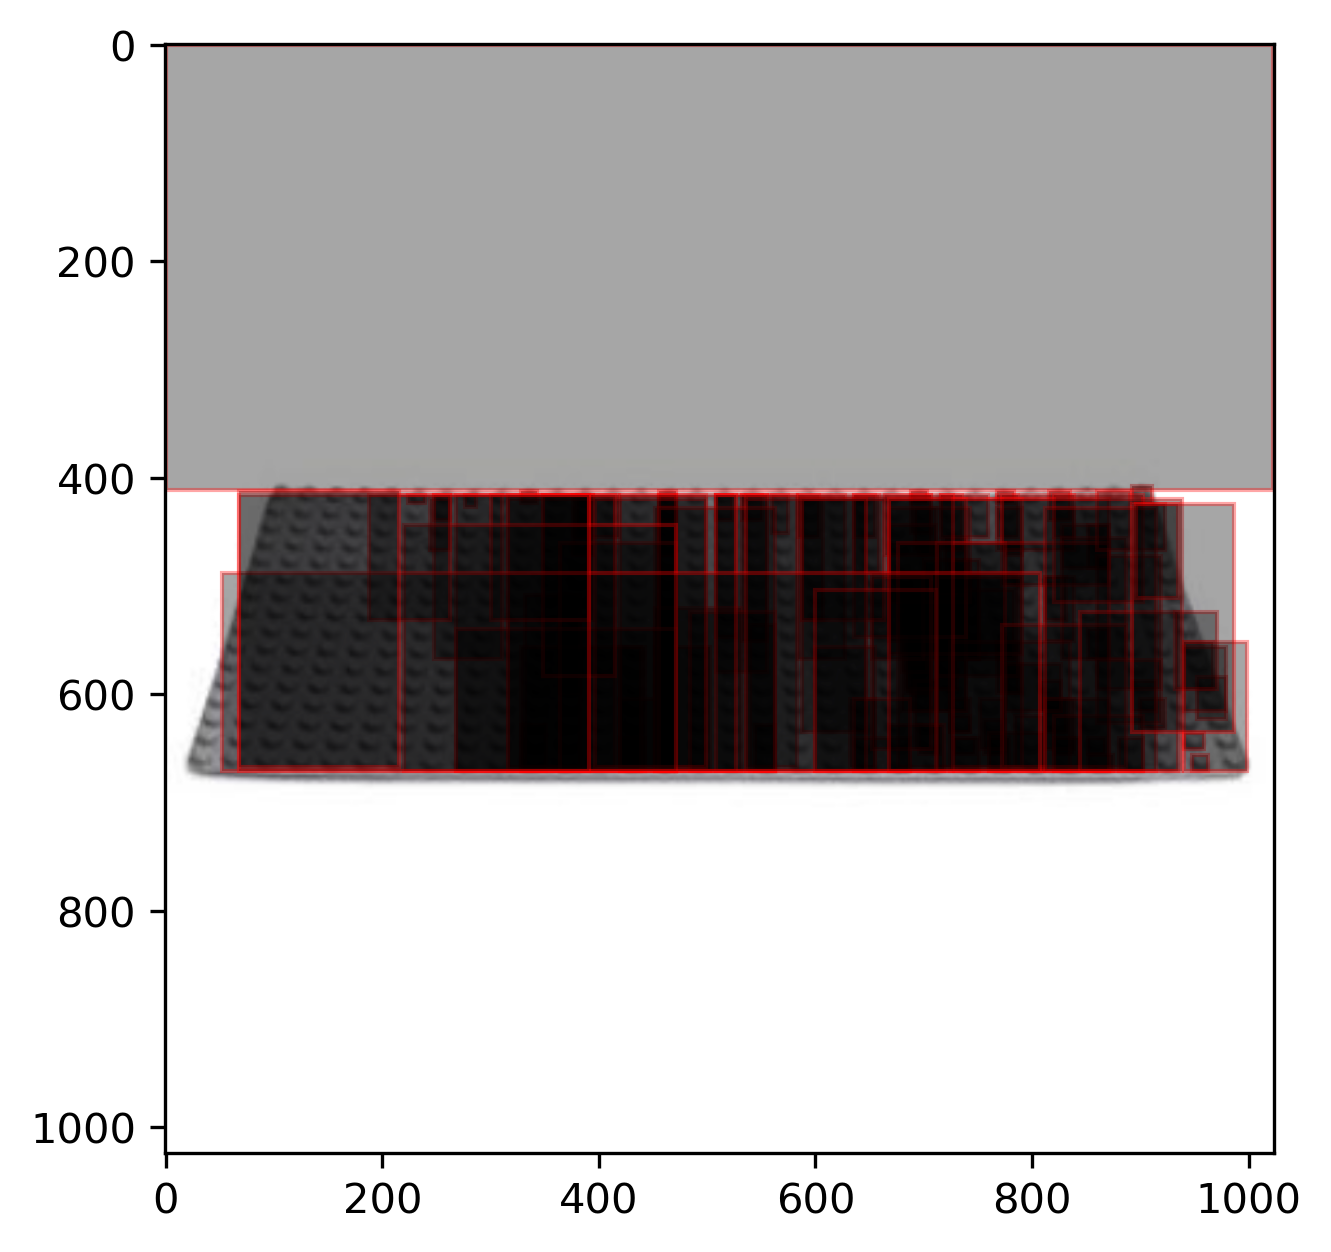

In [36]:
plot_results(read_image(fname),
             bboxes=pred_boxes[scores > 0.0],
            #  bboxes=pred_boxes,
             # bboxes=gt_boxes,
             # bboxes=all_data[fname]['box_examples_coordinates'],
             )

In [37]:
from detectron2.evaluation import COCOEvaluator
from detectron2.data.datasets import register_coco_instances
register_coco_instances("fsc_test_val", {}, f"{project_root}/data/fsc147/instances_test_val_bin.json",
                        f"{project_root}/data/fsc147/images_384_VarV2")

In [43]:
split = 'test' 
# split = 'val'
image_list = [fname for fname in all_data if all_data[fname]['split'] == split]

In [46]:
from detectron2.evaluation import COCOEvaluator

coco_evaluator = COCOEvaluator(dataset_name=f'fsc_test_val', tasks=['bbox', ],
                               output_dir='/home/zzhuang/temp', max_dets_per_image=1000)
coco_evaluator.reset()

from detectron2.structures import Boxes, ImageList, Instances, RotatedBoxes

all_predictions = {}

for fname in tqdm.tqdm(image_list):
    features = all_data[fname]['features'].cuda()
    with torch.no_grad():
        cls_head.eval()
        # few shot
        # example_features = all_data[fname]['example_clip_features'].cuda()
        # zero shot
        class_name = all_data[fname]['class_name']
        example_features = clip_text_prompts[class_name].unsqueeze(0).cuda()
        
    min_scores = 0.05
    max_points = 1000
    pred_points_score = all_data[fname]['predictions']['pred_points_score']
    mask = torch.zeros(pred_points_score.size(0))
    mask[:min(pred_points_score.size(0), max_points)] = 1
    mask[pred_points_score < min_scores] = 0
    pred_boxes = all_data[fname]['predictions']['pred_boxes'][:, :num_masks][mask.bool()].cuda()
    pred_ious = all_data[fname]['predictions']['pred_ious'][:, :num_masks][mask.bool()].cuda()

    all_pred_boxes = []
    all_pred_scores = []
    for indices in torch.arange(len(pred_boxes)).split(128):
        with torch.no_grad():
            cls_outs_ = cls_head(all_data[fname]['features'].cuda(), [pred_boxes[indices].reshape(-1, 4), ])
            pred_logits = cls_outs_[0].mm(example_features.T).mean(1).view(-1, num_masks)
            
            pred_logits = pred_logits * pred_ious[indices]

            all_pred_boxes.append(pred_boxes[indices, torch.argmax(pred_logits, dim=1)])
            all_pred_scores.append(pred_logits.max(dim=1).values)

    height, width = all_data[fname]['height'], all_data[fname]['width']
    scale = max(height, width) / 1024.
    pred_boxes = torch.cat(all_pred_boxes) * scale
    pred_boxes[:, [0, 2]] = pred_boxes[:, [0, 2]].clamp(0, width)
    pred_boxes[:, [1, 3]] = pred_boxes[:, [1, 3]].clamp(0, height)
    pred_scores = torch.cat(all_pred_scores)
    box_area = vision_ops.box_area(pred_boxes)
    mask = (box_area < (height * width * 0.75)) & (box_area > 10)
    pred_boxes = pred_boxes[mask]
    pred_scores = pred_scores[mask]
    
    nms_indices = vision_ops.nms(pred_boxes, pred_scores, 0.5)
    instances = Instances((height, width))
    pred_boxes = pred_boxes[nms_indices]
    pred_scores = pred_scores[nms_indices]
    instances.pred_boxes = Boxes(pred_boxes)
    instances.scores = pred_scores
    instances.pred_classes = torch.zeros(len(pred_boxes)).cuda().long()
    prediction = {"image_id": int(fname[:-4]), "instances": instances}
    coco_evaluator.process(
        [{'file_name': fname, 'height': height, 'width': width, 'image_id': int(fname[:-4])}],
        [prediction, ])
    all_predictions[fname] = prediction
    # break

100%|███████████████████████████████████████| 1189/1189 [00:25<00:00, 46.85it/s]


In [47]:
coco_evaluator.evaluate([int(x[:-4]) for x in image_list])

Loading and preparing results...
DONE (t=0.55s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=126.71s).
Accumulating evaluation results...
DONE (t=0.94s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.683
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.566
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | m

OrderedDict([('bbox',
              {'AP': 40.98181568219687,
               'AP50': 68.29374655022113,
               'AP75': 44.409688812713455,
               'APs': 25.701161884813402,
               'APm': 56.57651898519731,
               'APl': 38.733267217478854})])

In [ ]:
mae, mse, nae, sre = [], [], [], []
thresholds = np.arange(0, 1., 0.01)
for thresh in thresholds:
    total_mae = 0.
    total_mse = 0.
    total_nae = 0.
    total_sre = 0.
    for i, fname in enumerate(image_list):
        num_points = len(all_data[fname]['annotations']['points'])
        err = abs(num_points - (all_predictions[fname]['instances'].scores > thresh).sum())
        total_mae += err
        total_mse += err ** 2
        total_nae += err / num_points
        total_sre += err ** 2 / num_points
    cnt = len(image_list)
    mae.append(float(total_mae / cnt))
    mse.append(float((total_mse / cnt) ** 0.5))
    nae.append(float(total_nae / cnt))
    sre.append(float((total_sre / cnt) ** 0.5))
    # break
# min(mae), min(mse), mse[np.argmin(mae)], nae[np.argmin(mae)], sre[np.argmin(mae)], thresholds[np.argmin(mae)]
mae[np.argmin(mae)], mse[np.argmin(mae)], nae[np.argmin(mae)], sre[np.argmin(mae)], thresholds[np.argmin(mae)]

In [ ]:
thresh = 0.31
total_mae = 0.
total_mse = 0.
total_nae = 0.
total_sre = 0.
for i, fname in enumerate(image_list):
    num_points = len(all_data[fname]['annotations']['points'])
    err = abs(num_points - (all_predictions[fname]['instances'].scores > thresh).sum())
    total_mae += err
    total_mse += err ** 2
    total_nae += err / num_points
    total_sre += err ** 2 / num_points
cnt = len(image_list)

float(total_mae / cnt), float((total_mse / cnt) ** 0.5), float(total_nae / cnt), float((total_sre / cnt) ** 0.5)